# Projecte Node21: Classificació i Detecció de Nòduls Pulmonars en Radiografies de Pit.

## Introducció
En aquest projecte abordarem la detecció de nòduls pulmonars en radiografies de tòrax (CXR) seguint l'enunciat del repte **Node21** ([enllaç al repte](https://node21.grand-challenge.org/)). El repte Node21 proporciona un conjunt de dades públic de radiografies frontals de pit amb nòduls pulmonars anotats mitjançant **caixes delimitadores** (bounding boxes). En total consta d'aproximadament **4.882 radiografies**, de les quals **1.134** contenen almenys un nòdul i **3.748** imatges no en contenen, actuant com a casos negatius.  

L'objectiu consisteix en aplicar tècniques d'aprenentatge automàtic al problema proposat. S'han definit un **conjunt de tasques seqüencials** per tal de facilitar-ne el desenvolupament:

1. **Classificació**: Desenvolupar un sistema de classificació binària capaç de determinar si una radiografia conté nòduls pulmonars. Aquesta tasca es resoldrà mitjançant l'avaluació de **quatre models diferents**, alguns d'entrenats des de zero i d'altres aprofitant tècniques de *transfer learning*.
2. **Detecció**: Implementar models de detecció per localitzar els nòduls en la imatge, identificant-ne la posició amb caixes delimitadores. Per aquesta tasca es faran servir **dues arquitectures diferents** basades en *deep learning*.
3. **Innovació**: S’obre la possibilitat d’aplicar tècniques avançades o enfocaments propis que ampliïn o millorin les metodologies aplicades.

Per abordar aquestes tasques, utilitzarem un únic *notebook* Jupyter que integrarà tot el codi i explicacions necessàries. S'empraran diverses tècniques i models d'**aprenentatge automàtic** i **aprenentatge profund** vists a classe.


## Preparació de l'entorn i dependències
Abans de començar, assegurem-nos de tenir instal·lades totes les **dependències** necessàries. El projecte requerirà les biblioteqües següents:

- **NumPy** - per a manipulació de dades numèriques i de taules (anotacions).
- **PyTorch** - per construir i entrenar els models de CNN i Transfer Learning.
- **Matplotlib** - per a la visualizació de gràfiques i imatges.

Podem instal·lar els paquets que falten directament des del notebool. Per exemple:

`pip install torch torchvision scikit-learn matplotlib numpy`

També assegurarem una estructura de carpetes correcta en el directori de treball actual:

- `data/` - Contindrà les dades del NODE21 (imatges i anotacions).
- `utils/` - Codi de suport reutilitzable, com ara funcions d’augmentació, classes Dataset, funcions per dibuixar caixes, etc.
- `outputs/` - Elements de sortida.
- 

## Obtenció i preparació de les dades Node21

Per dur a terme les tasques de classificació i detecció de nòduls pulmonars, utilitzarem les dades proporcionades pel repte NODE21, descarregades des del repositori oficial de Zenodo. Aquest conjunt inclou radiografies de tòrax simulades amb nòduls inserits artificialment i anotacions detallades sobre la seva posició.

A causa de la mida del conjunt complet (~35 GB), no resulta eficient entrenar directament amb totes les imatges en un entorn personal. Per això, optarem per treballar amb un subconjunt configurable del total d’imatges, mantinguent una distribució equilibrada entre imatges positives (amb nòduls) i negatives (sense nòduls), que és fonamental per garantir una bona generalització del model.

Les imatges es troben dins la carpeta:

`data/cxr_images/proccessed_data/images/` 

i tenen format **.mha**. Les anotacions associades es troben al fitxer 

`data/cxr_images/proccessed_data/simulated_metadata.csv`

Aquest fitxer indica, per a cada nòdul simulat, a quina imatge apareix i amb quines coordenades **(x, y, width, height)**. Les imatges que no apareixen en aquest fitxer es consideren **negatives** (sense nòduls). Aquest enfocament ens permet construir tant:

- **Etiquetes binàries** per a classificació: 1 si hi ha algun nòdul, 0 si no.
- **Bounding boxes per detecció**: una o més caixes per imatge, o cap.

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Ruta a les imatges i anotacions
IMG_DIR = "data/cxr_images/proccessed_data/images"
ANNOTATION_FILE = "./data/cxr_images/proccessed_data/metadata.csv"

# Nombre total d'imatges a utilitzar (ajustable)
N_IMAGES = 2000  # Exemple: 500 imatges en total (positives + negatives)
VAL_RATIO = 0.25  # 25% per a validació
BATCH_SIZE = 32

# Mida d'entrada desitjada per al model (per exemple, 512x512)
IMG_SIZE = 512

In [2]:
# Carregam el CSV d'anotacions
df = pd.read_csv(ANNOTATION_FILE)

annotations_dict = {}
labels_dict = {}

for _, row in df.iterrows():
    img_id = str(row['img_name']).replace('.mha', '')  # treim extensió
    label = int(row["label"])
    
    # Guardam la label (si hi ha múltiples files per la mateixa imatge, max() manté 1 si n'hi ha qualque nòdul)
    if img_id in labels_dict:
        labels_dict[img_id] = max(labels_dict[img_id], label)
    else:
        labels_dict[img_id] = label

    # Guardam caixes només si és positiva i la caixa és vàlida
    if label == 1 and float(row["width"]) > 0 and float(row["height"]) > 0:
        box = [float(row["x"]), float(row["y"]), float(row["width"]), float(row["height"])]
        annotations_dict.setdefault(img_id, []).append(box)

# Asseguram que totes les imatges tenguin entrada a annotations_dict
for img_id in labels_dict.keys():
    annotations_dict.setdefault(img_id, [])

# Estadístiques
n_pos = sum(labels_dict[i] for i in labels_dict)
n_neg = len(labels_dict) - n_pos
print(f"Total imatges: {len(labels_dict)} | Positives: {n_pos} | Negatives: {n_neg}")

Total imatges: 4882 | Positives: 1134 | Negatives: 3748


In [3]:
# Extracció estratificada d’un subconjunt manejable
img_ids = list(labels_dict.keys())
img_labels = [labels_dict[i] for i in img_ids]

# Comprovació: assegurar que podem agafar N_IMAGES amb estratificació
if N_IMAGES > len(img_ids):
    print(f"[AVÍS] N_IMAGES={N_IMAGES} > total={len(img_ids)}. Es farà servir tot el conjunt.")
    N_IMAGES = len(img_ids)

# Si hi ha poques positives o negatives, ajusta N_IMAGES per assegurar almenys 1 de cada
min_class_count = min(sum(img_labels), len(img_labels) - sum(img_labels))
if min_class_count == 0:
    raise ValueError("No hi ha exemples d'una de les classes. Revisa anotacions o carpeta d'imatges.")

# Escollim N_IMAGES aleatòriament amb la mateixa proporció de classes
_, subsampled_ids, _, _ = train_test_split(
    img_ids, img_labels, test_size=N_IMAGES, stratify=img_labels, random_state=42)

# Partim en entrenament i validació (mantenint estratificació)
labels_subsampled = [labels_dict[i] for i in subsampled_ids]
X_train, X_val = train_test_split(
    subsampled_ids, test_size=VAL_RATIO, stratify=labels_subsampled, random_state=42)

print(f"Subconjunt: {len(subsampled_ids)} | Train: {len(X_train)} | Val: {len(X_val)}")

Subconjunt: 2000 | Train: 1500 | Val: 500


In [4]:
import SimpleITK as sitk

img_p = sitk.ReadImage("data/cxr_images/proccessed_data/images/c0875.mha")
arr_p = sitk.GetArrayFromImage(img_p)

print(f"Forma:  {arr_p.shape}")
print(f"Mínim: {arr_p.min()}")
print(f"Màxim: {arr_p.max()}")

Forma:  (1024, 1024)
Mínim: 0
Màxim: 4095


La imatge és **2D** (1024, 1024). El rang és fix i conegut **[0,4095]** (representació de 12 bits)

In [15]:
"""
CONVERTIR .MHA A .PNG

import SimpleITK as sitk
import cv2
import numpy as np

# Carpeta de sortida
OUTPUT_DIR = f"./data/preprocessed_{IMG_SIZE}"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def convert_and_resize(img_id, output_path):
    mha_path = os.path.join(IMG_DIR, f"{img_id}.mha")
    img = sitk.ReadImage(mha_path)
    arr = sitk.GetArrayFromImage(img)
          
    # Normalització per percentils
    p1, p99 = np.percentile(arr, (1, 99))
    arr_clipped = np.clip(arr, p1, p99)
    norm = ((arr_clipped - p1) / (p99 - p1)) * 255.0
    norm = norm.astype(np.uint8)
    
    resized = cv2.resize(norm, (IMG_SIZE, IMG_SIZE))
    cv2.imwrite(os.path.join(output_path, f"{img_id}.png"), resized)

# Convertim les imatges seleccionades
for img_id in X_train + X_val:
    convert_and_resize(img_id, OUTPUT_DIR)
"""


'\nCONVERTIR .MHA A .PNG\n\nimport SimpleITK as sitk\nimport cv2\nimport numpy as np\n\n# Carpeta de sortida\nOUTPUT_DIR = f"./data/preprocessed_{IMG_SIZE}"\nos.makedirs(OUTPUT_DIR, exist_ok=True)\n\ndef convert_and_resize(img_id, output_path):\n    mha_path = os.path.join(IMG_DIR, f"{img_id}.mha")\n    img = sitk.ReadImage(mha_path)\n    arr = sitk.GetArrayFromImage(img)\n          \n    # Normalització per percentils\n    p1, p99 = np.percentile(arr, (1, 99))\n    arr_clipped = np.clip(arr, p1, p99)\n    norm = ((arr_clipped - p1) / (p99 - p1)) * 255.0\n    norm = norm.astype(np.uint8)\n    \n    resized = cv2.resize(norm, (IMG_SIZE, IMG_SIZE))\n    cv2.imwrite(os.path.join(output_path, f"{img_id}.png"), resized)\n\n# Convertim les imatges seleccionades\nfor img_id in X_train + X_val:\n    convert_and_resize(img_id, OUTPUT_DIR)\n'

In [5]:
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset

class CXRClassificationDataSet(Dataset):
    def __init__(self, img_ids, labels_dict, img_dir, img_size, transform=None):
        self.img_ids = img_ids
        self.labels_dict = labels_dict
        self.img_dir = img_dir
        self.img_size = img_size
        self.transform = transform
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        label = self.labels_dict[img_id]
        
        # Ruta de la imatge .mha
        path = os.path.join(self.img_dir, f"{img_id}.mha")
        img = sitk.ReadImage(path)
        arr = sitk.GetArrayFromImage(img)
        
        # Normalització per percentils (millora el contrast)
        p1, p99 = np.percentile(arr, (1, 99))
        arr = np.clip(arr, p1, p99)
        arr = ((arr - p1) / (p99 - p1)) * 255.0
        arr = arr.astype(np.uint8)
        
        # Redimensionar a img_size x img_size
        arr_resized = cv2.resize(arr, (self.img_size, self.img_size))

        # Convertir a tensor (1 canal, H, W) i normalitzar a [0,1]
        tensor = torch.from_numpy(arr_resized).float().unsqueeze(0) / 255

        if self.transform:
            tensor = self.transform(tensor)

        return tensor, torch.tensor(label, dtype=torch.float32)

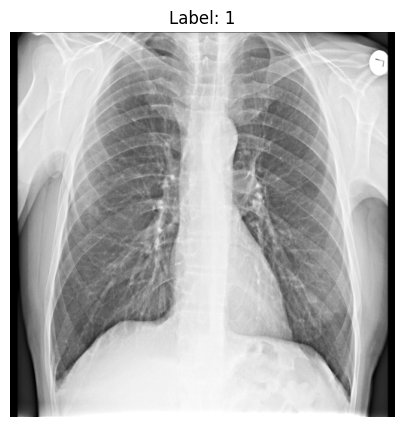

Tipus img: <class 'torch.Tensor'>
Shape img: torch.Size([1, 512, 512])
Min / Max img: 0.0 1.0
Label: 1.0


In [33]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

train_dataset = CXRClassificationDataSet(
    img_ids=X_train,
    labels_dict=labels_dict,
    img_dir=IMG_DIR,
    img_size=512
)

# 170 label 1 / 194 label 0
img, label = train_dataset[170]

plt.figure(figsize=(5, 5))
plt.imshow(img.squeeze(0), cmap="gray")
plt.title(f"Label: {int(label.item())}")
plt.axis("off")
plt.show()

print("Tipus img:", type(img))
print("Shape img:", img.shape)
print("Min / Max img:", img.min().item(), img.max().item())
print("Label:", label.item())

val_dataset = CXRClassificationDataSet(
    img_ids=X_val,
    labels_dict=labels_dict,
    img_dir=IMG_DIR,
    img_size=512
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [32]:
from sklearn.metrics import accuracy_score
from Node21 import TinyCXRNet

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

model = TinyCXRNet()

neg = sum(labels_dict[i] == 0 for i in X_train)
pos = sum(labels_dict[i] == 1 for i in X_train)

pos_weight = torch.tensor([neg / pos], dtype=torch.float32)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

EPOCHS = 5
running_loss, running_acc = [], []
running_val_loss, running_val_acc = [], []

for t in tqdm(range(EPOCHS), desc="Èpoques"):
    batch_loss = 0.0
    batch_acc = 0.0

    for i_batch, (x, y) in enumerate(train_loader):
        model.train()  # mode entrenament
        optimizer.zero_grad()
        
        y = y.float().view(-1, 1)
        # print("Sortida dades", y)
        
        y_pred = model(x)
                
        # 1. LOSS CALUCLATION
        loss = loss_fn(y_pred, y)
        
        # 2. GRADIENT
        loss.backward()
        
        # 3. OPTIMISATION
        with torch.no_grad():
            optimizer.step()
        
        # 5) EVALUACIÓ (sobre el mateix batch) - sense fer un segon forward
        model.eval()
        with torch.no_grad():
            batch_loss += loss.detach().item()

            # Probabilitats i classe (0/1)
            y_prob = torch.sigmoid(y_pred.detach())                # [B, 1]
            y_pred_class = (y_prob >= 0.5).long().view(-1).cpu().numpy()
            
            # print("Sortida model", y_pred_class)
            # Debug ocasional (no cada batch si no vols)
            if i_batch % 4 == 0:
                print("logits mean:", y_pred.mean().item(), "prob mean:", y_prob.mean().item())

            y_true = y.view(-1).long().cpu().numpy()
            
            print("Y pred:", y_pred_class)
            print("Y true:", y_true)
            batch_acc += accuracy_score(y_true, y_pred_class)

    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))
    
    # VALIDACIÓ
    batch_val_loss = 0.0
    batch_val_acc = 0.0

    model.eval()
    for i_batch, (x, y) in enumerate(val_loader):
        y = y.float().view(-1, 1)

        with torch.no_grad():
            y_logits = model(x)
            loss = loss_fn(y_logits, y)
            batch_val_loss += loss.detach().item()

            y_prob = torch.sigmoid(y_logits)
            y_pred_class = (y_prob >= 0.5).long().view(-1).cpu().numpy()
            y_true = y.view(-1).long().cpu().numpy()

            batch_val_acc += accuracy_score(y_true, y_pred_class)

    running_val_loss.append(batch_val_loss / (i_batch + 1))
    running_val_acc.append(batch_val_acc / (i_batch + 1))

    print(f"[Època {t+1}] Train loss {running_loss[-1]:.4f} acc {running_acc[-1]:.3f} | "
          f"Val loss {running_val_loss[-1]:.4f} acc {running_val_acc[-1]:.3f}")

Èpoques:   0%|          | 0/5 [00:00<?, ?it/s]

logits mean: 0.2717811167240143 prob mean: 0.5672862529754639
Y pred: [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Y true: [0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1]
Y pred: [1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1]
Y true: [0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0]
Y pred: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Y true: [1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0]
Y pred: [0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 0]
Y true: [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1]
logits mean: 0.27845141291618347 prob mean: 0.5679291486740112
Y pred: [1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1]
Y true: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0]
Y pred: [1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1]
Y true: [0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 

Èpoques:  20%|██        | 1/5 [05:20<21:20, 320.10s/it]

[Època 1] Train loss 1.0756 acc 0.562 | Val loss 1.5325 acc 0.769
logits mean: -0.41917935013771057 prob mean: 0.40395763516426086
Y pred: [0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0]
Y true: [0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
Y pred: [0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 0]
Y true: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0]
Y pred: [1 0 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1]
Y true: [1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1]
Y pred: [1 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0]
Y true: [1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1]
logits mean: -0.04678819701075554 prob mean: 0.4834660291671753
Y pred: [1 0 1 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0]
Y true: [0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
Y pred: [1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 

Èpoques:  40%|████      | 2/5 [10:55<16:27, 329.32s/it]

[Època 2] Train loss 0.5820 acc 0.842 | Val loss 6.4082 acc 0.231
logits mean: -1.846271276473999 prob mean: 0.267837256193161
Y pred: [0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0]
Y true: [0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0]
Y pred: [0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1]
Y true: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1]
Y pred: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1 0 0]
Y true: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0]
Y pred: [0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Y true: [0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
logits mean: -1.4043456315994263 prob mean: 0.31810882687568665
Y pred: [1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
Y true: [1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0]
Y pred: [0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 

Èpoques:  60%|██████    | 3/5 [16:41<11:13, 336.87s/it]

[Època 3] Train loss 0.4576 acc 0.893 | Val loss 2.2646 acc 0.769
logits mean: -1.2251677513122559 prob mean: 0.33340954780578613
Y pred: [0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 1]
Y true: [0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 1]
Y pred: [1 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0]
Y true: [1 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
Y pred: [0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1]
Y true: [0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1]
Y pred: [0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0]
Y true: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
logits mean: -0.6545255184173584 prob mean: 0.3976075053215027
Y pred: [1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1]
Y true: [1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1]
Y pred: [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 

Èpoques:  80%|████████  | 4/5 [22:29<05:41, 341.07s/it]

[Època 4] Train loss 0.3344 acc 0.928 | Val loss 10.2661 acc 0.231
logits mean: -1.3028442859649658 prob mean: 0.35381147265434265
Y pred: [0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0]
Y true: [0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0]
Y pred: [0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 1]
Y true: [0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1]
Y pred: [0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]
Y true: [0 0 1 1 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0]
Y pred: [0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0]
Y true: [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0]
logits mean: -0.4484792947769165 prob mean: 0.410073459148407
Y pred: [1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0]
Y true: [1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0]
Y pred: [1 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 

Èpoques: 100%|██████████| 5/5 [28:14<00:00, 338.87s/it]

[Època 5] Train loss 0.3106 acc 0.935 | Val loss 12.9961 acc 0.231


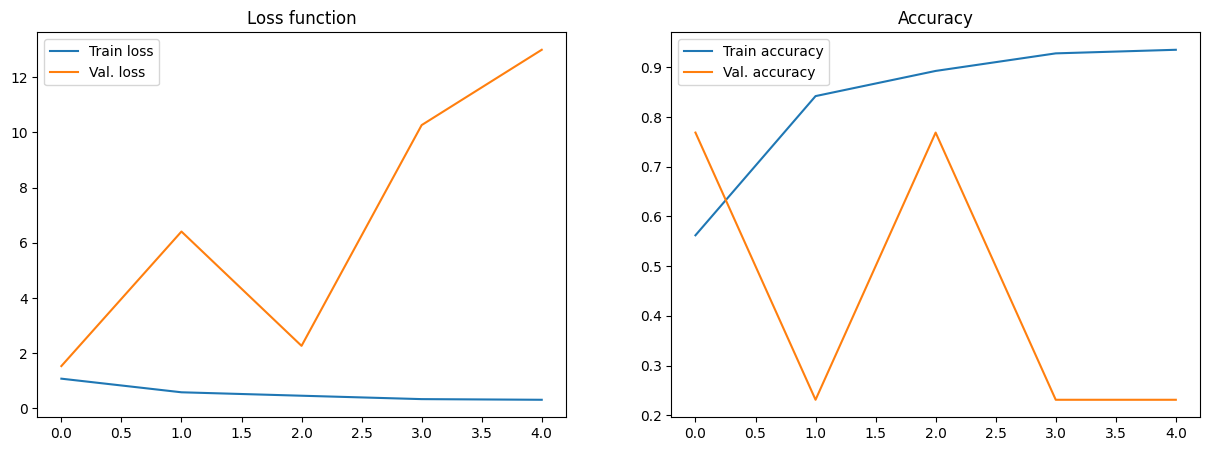

In [34]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.title("Loss function")
plt.plot(running_loss, label="Train loss")
plt.plot(running_val_loss, label="Val. loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(running_acc, label="Train accuracy")
plt.plot(running_val_acc, label="Val. accuracy")
plt.legend();

## Classificació

### Model 1

#### Capes de `TinyCXRNet` per a classificació binària (CXR 0/1)

- **Entrada**: radiografies de tòrax en escala de grisos, normalitzades a **[0, 1]**, amb forma **[B, 1, 512, 512]**.
- **Sortida**: classificació binària **0/1** (absència o presència de nòdul).
- **Idea general**: xarxa convolucional lleugera que extreu patrons visuals rellevants de la imatge i retorna un únic **logit** que es transforma en probabilitat mitjançant una funció sigmoide.


#### Convolucions 3×3 (`nn.Conv2d`)

Les capes convolucionals són les encarregades d’extreure patrons locals de la imatge, com vores, textures i petites variacions d’intensitat, que són especialment rellevants en radiografies pulmonars.

L’ús de kernels **3×3** permet capturar context local amb pocs paràmetres, i el `padding=1` manté la mida espacial de la imatge després de la convolució, evitant pèrdua d’informació als marges.


#### Increment progressiu de canals (16 → 32 → 64 → 128)

A mesura que la resolució espacial es redueix, augmenta el nombre de canals per mantenir la capacitat representacional del model.

- Els primers canals capturen patrons simples.
- Els canals més profunds combinen aquests patrons per descriure estructures més complexes i regions potencialment anòmales.


#### Normalització per lots (`nn.BatchNorm2d`)

La Batch Normalization s’utilitza per estabilitzar l’entrenament i reduir la variabilitat interna de les activacions.

En imatges mèdiques, on poden existir diferències d’adquisició i contrast, aquesta capa ajuda a fer el model més robust i accelera la convergència durant l’entrenament.


#### Downsampling amb MaxPool (`nn.MaxPool2d(2)`)

El MaxPool redueix la resolució espacial i el cost computacional, alhora que augmenta el camp receptiu de les capes profundes.

En aquest model s’apliquen tres operacions de MaxPool (512→256→128→64). No s’aplica un quart pooling final per evitar perdre massa detall espacial, ja que els nòduls poden ser estructures relativament petites.


#### Pooling adaptatiu mitjà i màxim  
(`AdaptiveAvgPool2d` i `AdaptiveMaxPool2d`)

Aquestes capes transformen els mapes de característiques finals a una mida fixa **4×4**, independentment de la resolució d’entrada, fent el model més flexible.

- **AdaptiveAvgPool2d** aporta informació global i context general de la imatge.
- **AdaptiveMaxPool2d** preserva activacions locals fortes, útils per detectar lesions petites.

La concatenació d’ambdues sortides combina context global i informació local en una única representació més rica.


#### Dropout (`nn.Dropout(p=0.3)`)

El Dropout s’utilitza com a tècnica de regularització per reduir el risc de sobreajust.

És especialment útil en contextos mèdics, on els conjunts de dades solen ser limitats o desbalancejats, ja que obliga el model a no dependre excessivament d’un subconjunt concret de neurones.


#### Sortida final de 1 logit (`nn.Linear(…, 1)`)

L’última capa produeix un únic valor real per imatge, que representa un **logit**.

Aquest logit es transforma en probabilitat mitjançant una funció sigmoide i permet entrenar el model amb `BCEWithLogitsLoss`, una formulació estable i adequada per a problemes de classificació binària.












### Model 2:

### Model 3:

### Model 4:

## Detecció

## Innovació